<a href="https://colab.research.google.com/github/carloshernangarrido/kalmanfilters/blob/main/time_domain_damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damage identification in beams using time-domain data extracted from video burst-records of free vibrations

# Packages and modules

In [ ]:
%reset-f
# Packages installation
!pip install 'filterpy==1.4.5'

# Modules import
from filterpy.kalman import KalmanFilter # based on the book Kalman_and_Bayesian_Filters_in_Python.pdf
import pkg_resources
pkg_resources.require("numpy==1.21.6")  # modified to use specific numpy
pkg_resources.require("scipy==1.4.1")  # modified to use specific numpy
import numpy as np
import scipy.io
from scipy.signal import butter, lfilter
from scipy.optimize import minimize 

# import scipy.stats
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Input parameters

## Classes

In [ ]:
class InputParameters: 
  '''
  Description
  ----------
  An object of Input Parameters for a Kalman Filter.

  Atributes
  ----------
  files : list of str
    List containing the file names where displacements are stored.
  dim_x : int
    State vector dimension. The default state vector 
    dimension is 3, i.e. x_1 = position, x_2 = slope, and x_3 = curvature.
  dim_z : int
    Meassurement vector dimension. The default meassurement 
    vector dimension is 1, i.e. z = position.
  x_init : ndarray(dim_x, 1)
    Initial state
  dx : float
    Step size (Delta t)
  n_steps : int
    Number of steps used for batch filtering.
  r : float
    Meassurement noise as standard deviation, asuming only position is 
    meassured.
  q : float
    Curvature disturbances as standard deviation, assuming only curvature is 
    disturbed. Q_process_noise_var has more priority than q.
  h_d : int
    Radius of apparent damage extent (in points).
  L_d : int
    Apparent length of damage (in points).
  L_ch : int
    Characteristic length of damage (in points).
  H_EI_typ : float
    Typical damage measured as a ratio between damaged stiffness and healthy 
    stiffness. That is H_EI_typ = 0.5 # (EI_d / EI_h) = (curv_h / curv_d)
  ntdc : float
    Normalized typical deviation of curvature due to damage, calculated as
    ntdc = (1/ip.H_EI_typ) - 1# (curv_d - curv_h)/curv_h.
  Q_process_noise_var : float
    process noise variance used to calculate Q from F. This parameter has more 
    priority than q. For using q, left Q_process_noise_var=None.
  F : ndarray(dim_x, dim_x)
    State transition matrix. By default, it assumes constant slope and that 
    the next position is the current position plus current slope times dx
  H : ndarray(dim_z, dim_x)
    Meassurement function. By default, it assumes that only the position is 
    meassured.
  P : ndarray(dim_x, dim_x)
    Covariance matrix describing the uncertainty in the state vector due to 
    disturbances that excite the system. By default it is assumed that position 
    cannot change suddenly but velocity can change during a time step with a 
    variance of std**2.
  R : ndarray(dim_z, dim_z)
    Covariance matrix describing the measurement noise. If only position is 
    meassured, it can be set as a scalar. By default, it assumes a variance of \
    1 for the noise in the position meassurement std**2.
  Q : ndarray(dim_x, dim_x)
    Variance matrix describing the process noise.
  Qs : list(n_steps)
    List of self.n_steps matrices as Q.
  '''
    
  def update_Q(self, Q=None, Q_process_noise_var=None, q=None):
    if Q is None:
      if Q_process_noise_var is None:
        if q is None:
          raise Exception("If process noise covariance matrix is not defined, \
and process noise variance Q_process_noise_var is not defined, disturbance \
standard deviation q must be defined.")
        else:
          self.q = q
          self.Q = np.zeros((3,3))
          self.Q[2,2] = q**2
      else:
        from filterpy.common import Q_discrete_white_noise
        self.Q_process_noise_var = Q_process_noise_var
        self.Q = Q_discrete_white_noise(dim=dim_x, dt=dx, var=Q_process_noise_var)
    else:
      self.Q = Q

  def update_F(self, F=None, dx=None):
    self.dx = dx
    if F is None:
      if dx is not None:
        self.F = np.array([[1., dx, 0.5*(dx**2)], 
                           [0., 1.,      dx],
                           [0., 0.,      1.]]) 
      else:
        raise Exception("If State transition matrix F is not defined, step size\
dx must be defined.")
    else:
      self.F = F

  def update_R(self, R=None, r=None):
    if R is None:
      if r is None:
        raise Exception("If meassurement noise covariance matrix R is not  \
defined, meassurement noise standard deviation in position r must be defined.")
      else:
        R=np.array([[r**2]])
        self.R = R
    else:
      self.R = R

  def update_P(self, P=None):
    if P is None:
      self.P = 1e6*np.array([[self.R[0,0], 0.,                       0.], 
                           [0.,          self.R[0,0]/(self.dx**2), 0.],
                           [0.,          0.,                       self.R[0,0]/(self.dx**4)]])
    else:
      self.P = P

  def __init__(self, files=None, dim_x=3, dim_z=1, x_init=np.array([[0.], [0.], [0.]]),\
               dx=1, n_steps=None, h_d=None, H_EI_typ=None, r=None, q=None, \
               F=None, H=np.array([[1., 0., 0.]]), P=None, R=None, Q=None, \
               Q_process_noise_var=None):  

    if files is None:
      self.files = []
    self.files = files
    self.dim_x = dim_x
    self.dim_z = dim_z
    if x_init.shape == (dim_x,1):
      self.x_init = x_init
    else:
      raise Exception("Initial state must have the same dimension as the state")
    self.dx = dx

    self.n_steps = n_steps

    self.h_d = h_d
    self.L_d = 2*self.h_d    
    self.L_ch = 3*self.L_d
    self.H_EI_typ = H_EI_typ
    self.ntdc = (1/self.H_EI_typ) - 1 # (curv_d - curv_h)/curv_h
    
    self.update_F(F, dx)

    self.H = H

    self.update_R(R, r)
    
    self.update_Q(Q, Q_process_noise_var, q)

    self.update_P(P)

    if self.n_steps is None:
      self.Qs = []
    else:
      self.Qs = [self.Q] * self.n_steps

  
class TimeHistory:
  '''
  Description
  ----------
  An object of time histories.

  Attributes
  ----------
  file_name : str
    File name including full path
  _name : str
    Name extracted from file_name
  S : dict
    This dict initializes the object. It must be a dictionary returned by 
    scipy.io.loadmat(input_file_name)
  x : ndarray(n_points, 1)
    positions of points along the beam axis
  t : ndarray(1, n_time_instants)
    time along the time  
  initial_time : float
    minimum time considered in s
  final_time : float
    maximum time considered in s
  cutt_off_freq : float
    cutt off frequency for a first order butterworth low pass filter. If None, 
    no filter is applied.
  D_ : ndarray(n_points, n_time_instants)
    matrix of transverse static displacements of the beam
  D : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic displacements of the beam
  S_ : ndarray(n_points, n_time_instants)
    matrix of transverse static slopes of the beam
  S : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic slopes of the beam
  C_ : ndarray(n_points, n_time_instants)
    matrix of transverse static curvatures of the beam        
  C : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic curvatures of the beam        
  V : ndarray(n_points, n_time_instants)
      matrix of transverse velocities of the beam    
  A : ndarray(n_points, n_time_instants)
    matrix of transverse accelerations of the beam
  '''  

  def __init__(self, S, file_name=None, 
               initial_time=None, final_time=None, cut_off_freq=None):
    self.file_name = file_name
    if self.file_name is None:
      self._name = None
    else:
      head, tail = os.path.split(self.file_name)
      self._name = tail[0:-4]

    # Extraction of static displacements
    self.initial_time = initial_time
    self.final_time = final_time
    self.cut_off_freq = cut_off_freq
    self.x = np.array(S['displacements']['x'][0][0], dtype=np.float64) 
    self.D_ = np.array(S['displacements']['D'][0][0], dtype=np.float64) 
    self.t = np.array(S['displacements']['t'][0][0], dtype=np.float64)

    # Low-pass Filtering of static displacements
    if self.cut_off_freq != 0:
      b, a = butter(N=1, Wn=self.cut_off_freq, 
                    fs=1/np.mean(np.diff(self.t)), btype='low', analog=False)
      self.D_ = lfilter(b, a, self.D_)

    # Time cropping
    if self.initial_time is None:
      self._initial_time_ind = 0
    else:  
      self._initial_time_ind = np.argmin(np.abs(self.t - self.initial_time))
    
    if self.final_time is None:
      self._final_time_ind = self.D_.shape[1]
    else:
      self._final_time_ind = np.argmin(np.abs(self.t - self.final_time))
    
    self.D_ = self.D_[:,self._initial_time_ind:self._final_time_ind]
    self.t = self.t[:,self._initial_time_ind:self._final_time_ind]
   
    self.n_points = self.D_.shape[0]
    self.n_time_instants = self.D_.shape[1]

    # Initial calculation of curvatures
    self.S_ = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    self.C_ = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    for j in range(self.n_time_instants):
      # self.S_[:, j] = (np.diff(self.D_[:, j].reshape(-1,1), 1, axis=0,  append=0) \
      #                 / np.diff(self.x, 1, axis=0,  append=np.nan)).reshape(-1,)
      # self.C_[:, j] = (np.diff(self.S_[:, j].reshape(-1,1), 1, axis=0, prepend=0) \
      #                 / np.diff(self.x, 1, axis=0, prepend=np.nan)).reshape(-1,)
      self.S_[:, j] = (np.diff(self.D_[:, j], append=0) \
                      / np.diff(self.x[:, 0], append=np.nan))
      self.C_[:, j] = (np.diff(self.S_[:, j], prepend=0) \
                      / np.diff(self.x[:, 0], prepend=np.nan))      
      self.S_[-1, j] = self.S_[-2, j]
      self.C_[0, j] = self.C_[1, j]
      self.C_[-1, j] = self.C_[-2, j]
 
    # Retain dynamic displacements, slopes and curvatures
    self.D = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    self.S = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    self.C = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    for i in range(self.n_points):
      self.D[i, :] = self.D_[i, :] - np.mean(self.D_[i, :], axis=0)
      self.S[i, :] = self.S_[i, :] - np.mean(self.S_[i, :], axis=0)
      self.C[i, :] = self.C_[i, :] - np.mean(self.C_[i, :], axis=0)

    # Calculation of velocities and accelerations
    # Initial calculation of curvatures
    self.V = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    self.A = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    for i in range(self.n_points):
      self.V[i, :] = np.diff(self.D[i,:], append=0) / \
       np.diff(self.t[0,:], append=np.nan)
      self.A[i, :] = np.diff(self.V[i,:], prepend=0) / \
       np.diff(self.t[0,:], prepend=np.nan)  
      self.V[i, -1] = self.V[i, -2]
      self.A[i, 0] = self.A[i, 1]
      self.A[i, -1] = self.A[i, -2]       



## Functions

In [ ]:
def fun(x, C, M_, norm):
  dyn_stiff = x[0]
  S_0 = x[1]
  M_0 = x[2]
  X = range(len(M_))
  __M = M_ + M_0 + X*S_0
  error = C - __M/dyn_stiff
  loss = np.linalg.norm(error, ord=norm)
  return loss

def hsmr_synthesis(c, q):
  """
  Description
  -----------
  A funtion that returns a curvature corresponding to the healthy structure 
  (beam) in a Region Of Interest (ROI), given the curvature of the actual 
  structure (beam) c and the load q applied to the corresponding ROI. This
  function assumes the damage in the ROI is sparse.
  References: Garrido, Domizio, Curadelli, Ambrosini. Synthesis of healthy-
  structure model responses for damage quantification, Structural Health 
  Monitoring (Internation Journal), 2022.

  Parameters
  ----------
  c : ndarray(n,)
    Curvature shape of the actual beam in the ROI.
  q : ndarray(n,)
    Loading shape of the actual beam in the ROI.    

  Returns
  -------
  c_h : ndarray(n,)
    Curvature shape of the healthy ROI.
  m_ : ndarray(n,)
    Bending moment with null integration constants.    
  m : ndarray(n,)
    Bending moment with apropriate integration constants and dynamic stiffness.     
  res_x : tuple(3,)
    Dynamic stiffness, initiual shear and initial bending moment.

  """
  x0 = (1, 0, 0) # dyn_stiff, S_0, M_0
  # bending moment with null integration constants
  m_ = np.cumsum(np.cumsum(q))
  # normalization
  m_ = m_ * np.linalg.norm(c, ord=np.inf) / np.linalg.norm(m_, ord=np.inf)
  # bending moment with apropriate integration constants and dynamic stiffness
  res = minimize(fun, x0, method='SLSQP', args=(c, m_, 1))
  dyn_stiff = res.x[0]
  s_0 = res.x[1] # initial shear
  m_0 = res.x[2] # initial bending moment  
  res_x = (dyn_stiff, s_0, m_0)
  m = m_ + m_0 + range(len(m_))*s_0
  # Healthy curvature
  c_h = m/dyn_stiff
  return c_h, m_, m, res_x

## Loading

In [ ]:
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain/get displacements/60dofs'
files = ['00_00_00_run1.mat', 
         '05_00_00_run1.mat', 
         '10_00_00_run1.mat', 
         '13_00_00_run1.mat', 
         '13_05_00_run1.mat', 
         '13_05_05_run1.mat', 
         '13_10_05_run1.mat', 
         '13_10_11_run1.mat']
ip = InputParameters(
    files=[os.path.join(path, files[i]) for i in range(len(files))], 
    h_d=3, H_EI_typ=0.2, r=0, q=0)

ths = [TimeHistory(scipy.io.loadmat(file_name), file_name=file_name,
                   initial_time=.5, final_time=2.5, cut_off_freq=.5) 
       for file_name in ip.files]



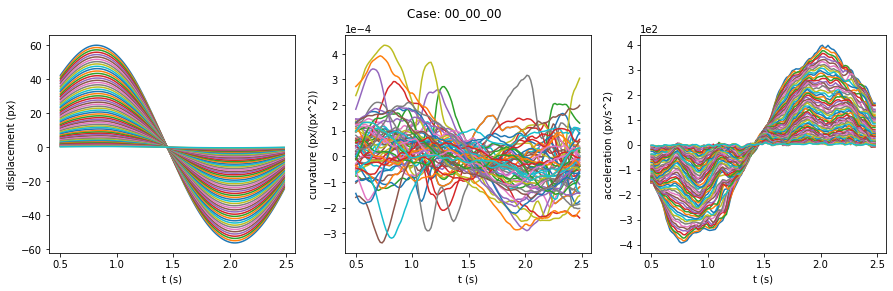

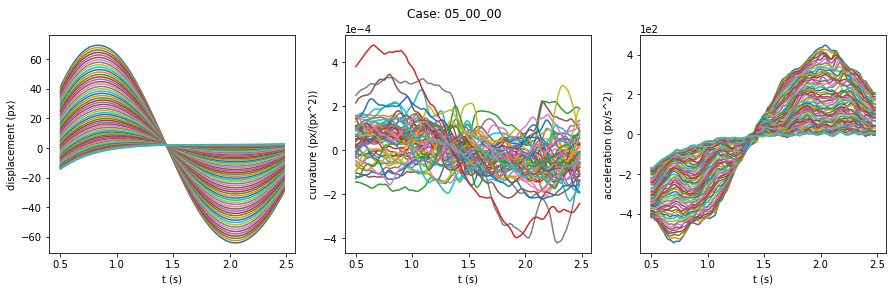

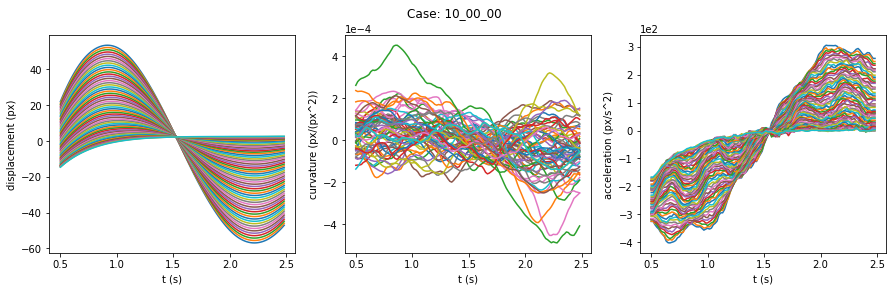

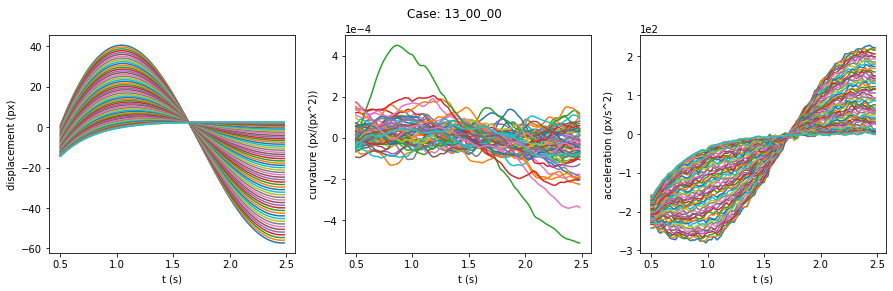

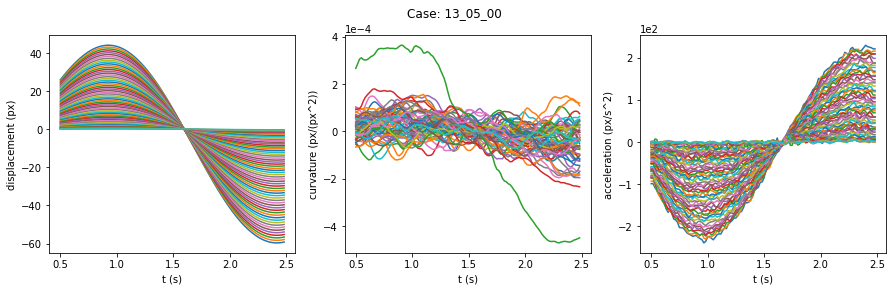

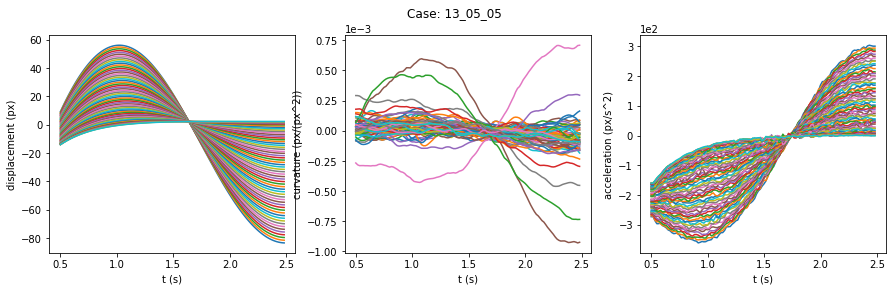

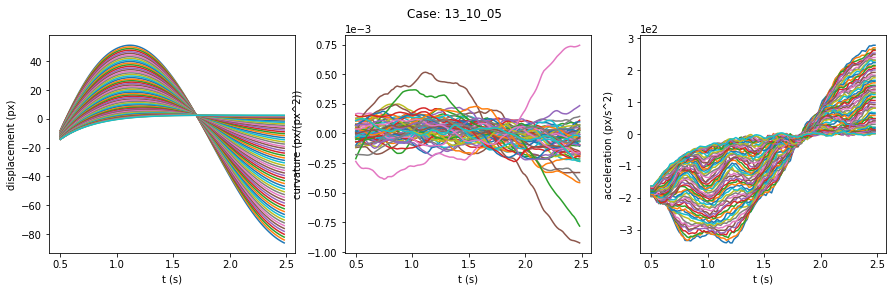

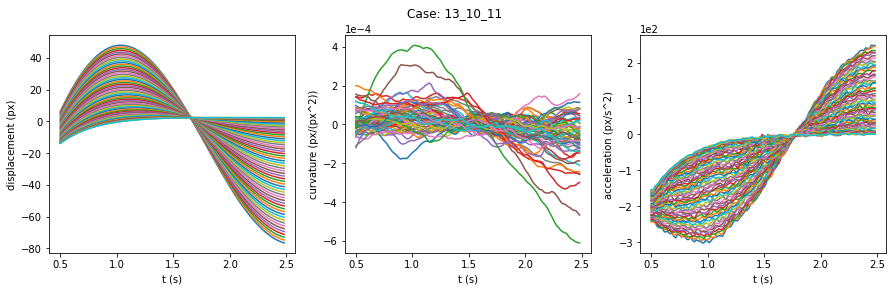

In [ ]:
fig_size = (15,4)
for th in ths:
  fig, ax = plt.subplots(1,3, sharey=False, figsize=fig_size)
  fig.suptitle(f'Case: {th._name[0:-5]}')
  # ax[0].plot(th.x, th.C)
  # ax[0].set_xlabel('x (px)')
  # ax[0].set_ylabel('curvature (px/(px^2))')
  ax[0].plot(th.t.T, th.D.T)
  ax[0].set_xlabel('t (s)')
  ax[0].set_ylabel('displacement (px)')  
  ax[0].ticklabel_format(axis='y', scilimits=[-2, 2])
  ax[1].plot(th.t.T, th.C.T)
  ax[1].set_xlabel('t (s)')
  ax[1].set_ylabel('curvature (px/(px^2))')
  ax[1].ticklabel_format(axis='y', scilimits=[-2, 2])
  ax[2].plot(th.t.T, th.A.T)
  ax[2].set_xlabel('t (s)')
  ax[2].set_ylabel('acceleration (px/s^2)')  
  ax[2].ticklabel_format(axis='y', scilimits=[-2, 2])
  plt.show

# Pre-processing

## Detect the time instant of minimum and maximum rms curvature

### Extraction of intantaneous curvatures and accelerations

In [ ]:
max_curv_lim = 0
cases = {}
for th in ths:
  rms_accel = np.sqrt(np.mean(th.A**2, axis=0))
  rms_curv = np.sqrt(np.mean(th.C**2, axis=0))
  rms_disp = np.sqrt(np.mean(th.D**2, axis=0))
  peak_curv = np.max(np.abs(th.C), axis=0)
  peak_disp = np.max(np.abs(th.D), axis=0)
  max_curv_ind, min_curv_ind = np.argmax(rms_curv), np.argmin(rms_curv)
  if np.max(np.max(np.abs(th.C))) > max_curv_lim:
    max_curv_lim = np.max(np.max(np.abs(th.C)))
  cases[th._name] = \
    {'min_curv': {'x': th.x, 'C': th.C[:,min_curv_ind], 'S': th.S[:,min_curv_ind], 'D': th.D[:,min_curv_ind], 'D_': th.D_[:,min_curv_ind], 'A': th.A[:,min_curv_ind]},
     'min_curv_rms': rms_curv[min_curv_ind],
     'min_curv_disp_rms': np.sqrt(np.mean(th.D[:,min_curv_ind]**2, axis=0)),
     'max_curv': {'x': th.x, 'C': th.C[:,max_curv_ind], 'S': th.S[:,max_curv_ind], 'D': th.D[:,max_curv_ind], 'D_': th.D_[:,max_curv_ind], 'A': th.A[:,max_curv_ind]},
     'max_curv_rms': rms_curv[max_curv_ind],
     'max_curv_disp_rms': np.sqrt(np.mean(th.D[:,max_curv_ind]**2, axis=0)),
     'max_curv_median': {'x': th.x, 'C': 
                         scipy.ndimage.median_filter(th.C[:,max_curv_ind], 
                                                     size=ip.L_ch, 
                                                     mode='mirror')}}


### Plot curvatures and accelerations

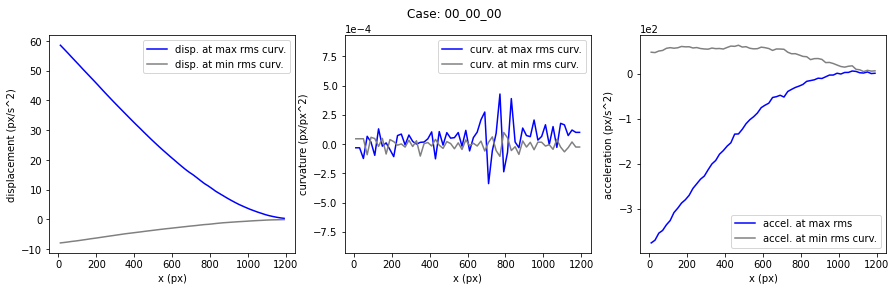

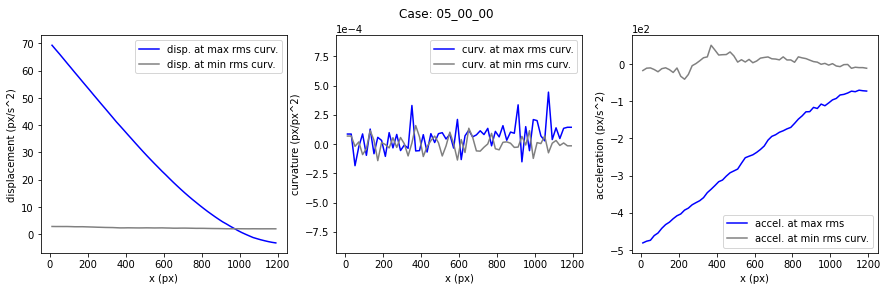

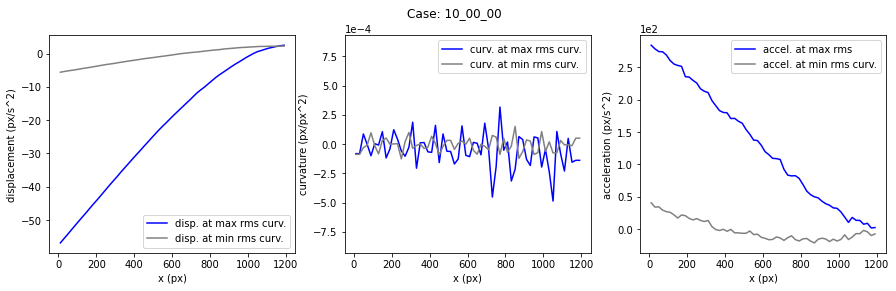

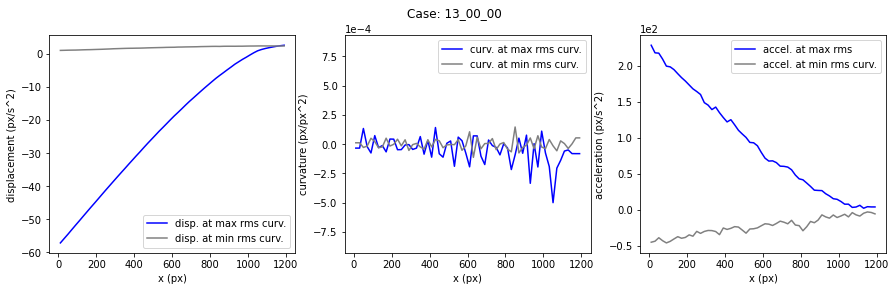

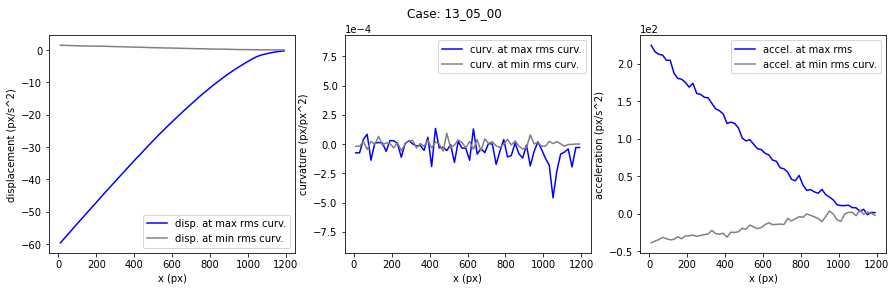

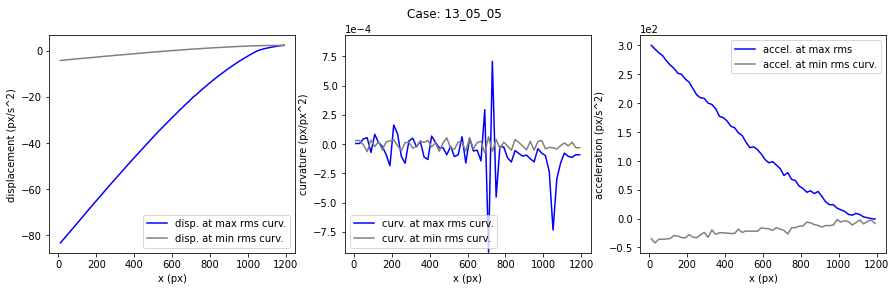

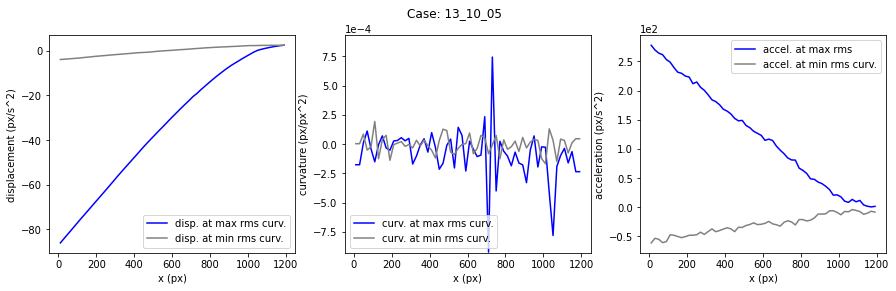

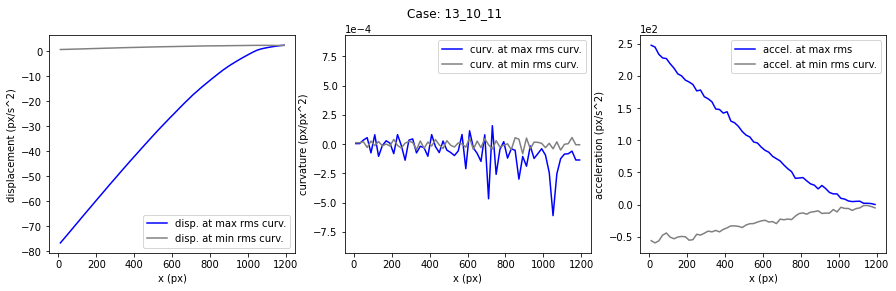

In [ ]:
for key in cases.keys():
  fig, axs = plt.subplots(1,3, figsize=fig_size)
  fig.suptitle(f"Case: {key[0:-5]}")

  axs[0].set_ylabel('displacement (px/s^2)') 
  axs[0].set_xlabel('x (px)') 
  axs[0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['D'],
              color='blue', label='disp. at max rms curv.')
  axs[0].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['D'],
              color='gray', label='disp. at min rms curv.')
  axs[0].ticklabel_format(axis='y', scilimits=[-2, 2]) 
  axs[0].legend() 

  axs[1].set_ylabel('curvature (px/px^2)')
  axs[1].set_xlabel('x (px)')
  axs[1].set_ylim((-max_curv_lim, max_curv_lim))
  axs[1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
              color='blue', label='curv. at max rms curv.')
  axs[1].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['C'],
              color='gray', label='curv. at min rms curv.')  
  axs[1].ticklabel_format(axis='y', scilimits=[-2, 2]) 
  axs[1].legend()

  axs[2].set_ylabel('acceleration (px/s^2)') 
  axs[2].set_xlabel('x (px)')
  axs[2].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['A'],
              color='blue', label='accel. at max rms')
  axs[2].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['A'],
              color='gray', label='accel. at min rms curv.')    
  axs[2].ticklabel_format(axis='y', scilimits=[-2, 2]) 
  axs[2].legend()
plt.show()

## Sinthesys of healthy structure model response, using meassured curvature

In [ ]:
for key in cases.keys():
  C_h, M_, M, _ = hsmr_synthesis(
      c=cases[key]['max_curv']['C'], 
      q=cases[key]['max_curv']['A'])
  # bending moment with null integration constants
  cases[key]['max_curv'].update({'M_': M_})
  # bending moment with apropriate integration constants and dynamic stiffness
  cases[key]['max_curv'].update({'M': M})  
  # healthy curvature
  cases[key]['max_curv'].update({'C_h': C_h})


### Plot of instantaneous curvature and bending moment

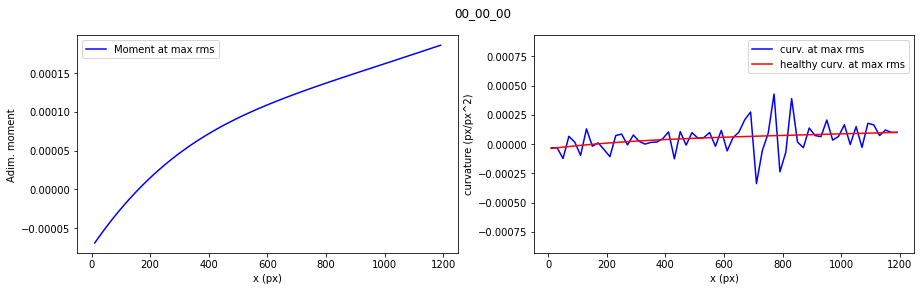

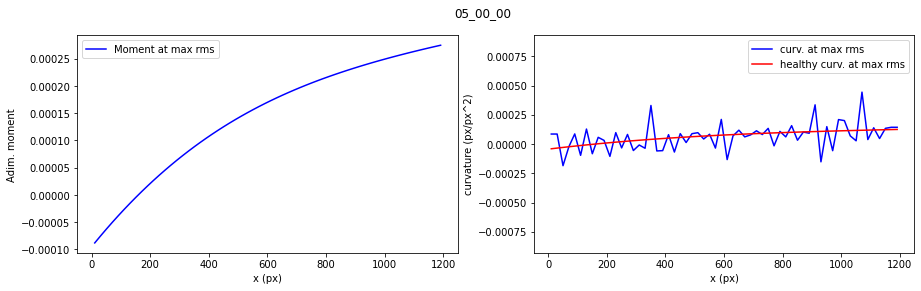

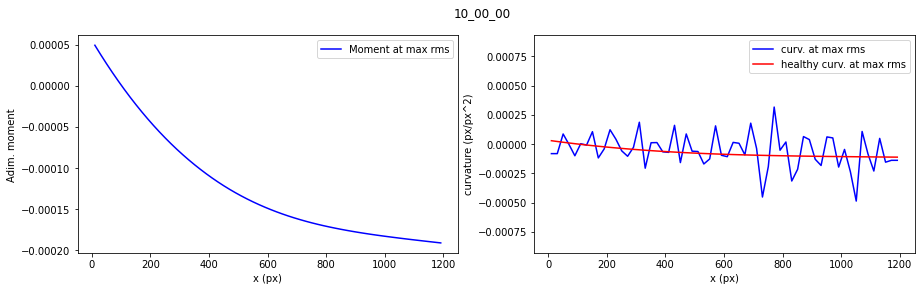

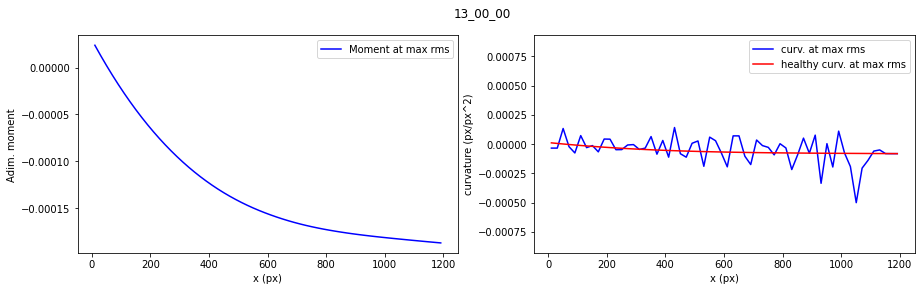

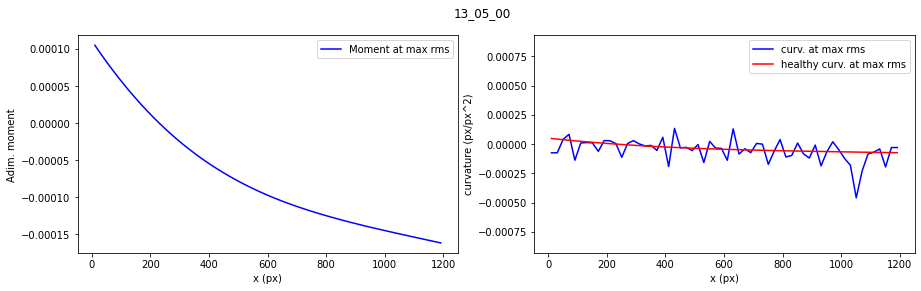

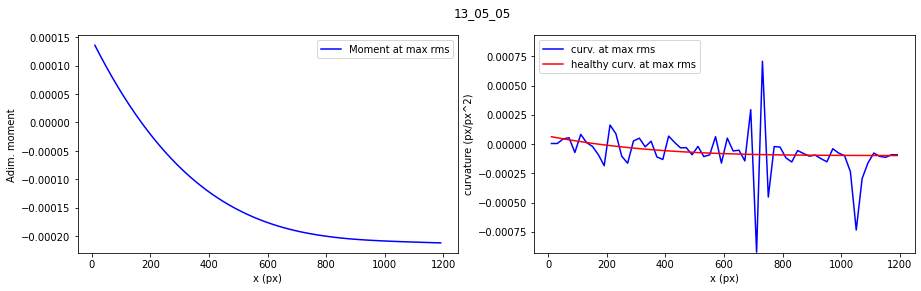

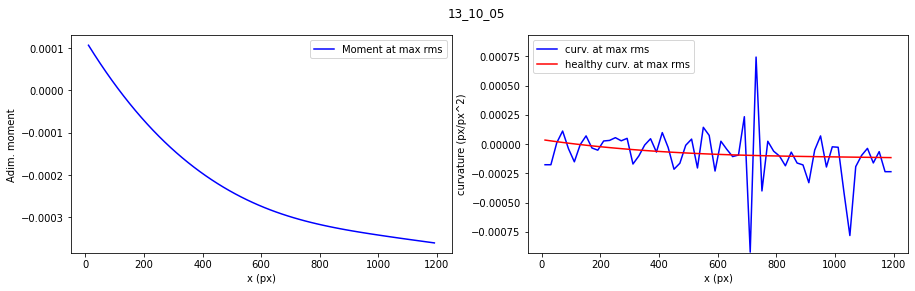

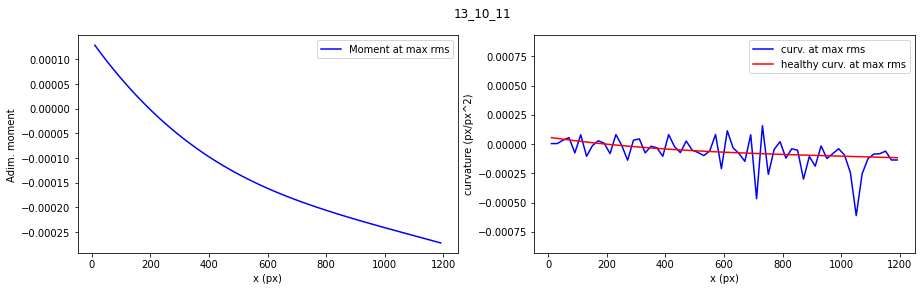

In [ ]:
for key in cases.keys():
  fig, axs = plt.subplots(1,2, figsize=fig_size)
  fig.suptitle(f"{key[0:-5]}")
  axs[0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['M'],
              color='blue', label='Moment at max rms')
  # axs[0].set_ylim((-max_curv_lim, max_curv_lim))
  axs[0].set_ylabel('Adim. moment')
  axs[0].set_xlabel('x (px)')
  axs[0].legend()    
  axs[1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
              color='blue', label='curv. at max rms')
  axs[1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C_h'],
              color='red', label='healthy curv. at max rms')  
  axs[1].set_ylim((-max_curv_lim, max_curv_lim))
  axs[1].set_ylabel('curvature (px/px^2)')
  axs[1].set_xlabel('x (px)')
  axs[1].legend()

# Post-processing

### Filtering of meassured curvatures using kalman Filters

In [ ]:
noise_factor = 1
for key in cases.keys():
  cases[key]['kf'] = KalmanFilter(dim_x=ip.dim_x, dim_z=ip.dim_z)
  ip.update_F(dx=np.mean(np.diff(cases[key]['min_curv']['x'], axis=0)))
  # Construct ip.Qs as a list
  ip.Qs = []
  for healthy_value in cases[key]['max_curv']['C_h']:
    # ip.update_R(r=0)
    ip.update_Q(q=ip.ntdc*healthy_value)
    ip.Qs.append(ip.Q.copy())
  ip.update_R(r=cases[key]['min_curv_disp_rms']*noise_factor)
  ip.update_P()
  ip.x_init[0] = cases[key]['max_curv']['D'][0]
  ip.x_init[1] = cases[key]['max_curv']['S'][0]
  ip.x_init[2] = cases[key]['max_curv']['C'][0]
  cases[key]['kf'].x, cases[key]['kf'].F, cases[key]['kf'].H, cases[key]['kf'].P, cases[key]['kf'].R, cases[key]['kf'].Q = \
  ip.x_init, ip.F, ip.H, ip.P, ip.R, ip.Q

  ## Adaptive Rauch, Tung, and Striebel
  mu_adapt, cov_adapt, _, _ = cases[key]['kf'].batch_filter(zs=cases[key]['max_curv']['D'], Qs=ip.Qs)
  M_adapt, P_adapt, C_adapt, _ = cases[key]['kf'].rts_smoother(mu_adapt, cov_adapt)
  x_vector_adapt = mu_adapt.T.reshape((3,-1))
  z_vector_filt_adapt = x_vector_adapt[0,:].reshape((1,-1))
  s_vector_filt_adapt = x_vector_adapt[1,:].reshape((1,-1))
  c_vector_filt_adapt = x_vector_adapt[2,:].reshape((1,-1))
  x_vector_rts_adapt = M_adapt.T.reshape((3,-1))
  z_vector_filt_rts_adapt = x_vector_rts_adapt[0,:].reshape((1,-1))
  s_vector_filt_rts_adapt = x_vector_rts_adapt[1,:].reshape((1,-1))
  c_vector_filt_rts_adapt = x_vector_rts_adapt[2,:].reshape((1,-1))
  cases[key]['max_curv_filt_rts_adapt'] = {'x': cases[key]['max_curv']['x'],
                                           'D': z_vector_filt_rts_adapt.reshape(-1,),
                                           'S': s_vector_filt_rts_adapt.reshape(-1,),
                                           'C': c_vector_filt_rts_adapt.reshape(-1,)}                                       




### Estimation of damage

In [ ]:
for key in cases.keys():
  # using a HSMR from meassured curvature
  cases[key]['H_EI'] = {'x': cases[key]['max_curv']['x'],
                        'H_EI': cases[key]['max_curv']['C_h'] / \
                        cases[key]['max_curv_filt_rts_adapt']['C']}                   

# Results

### Plot curvatures and damage

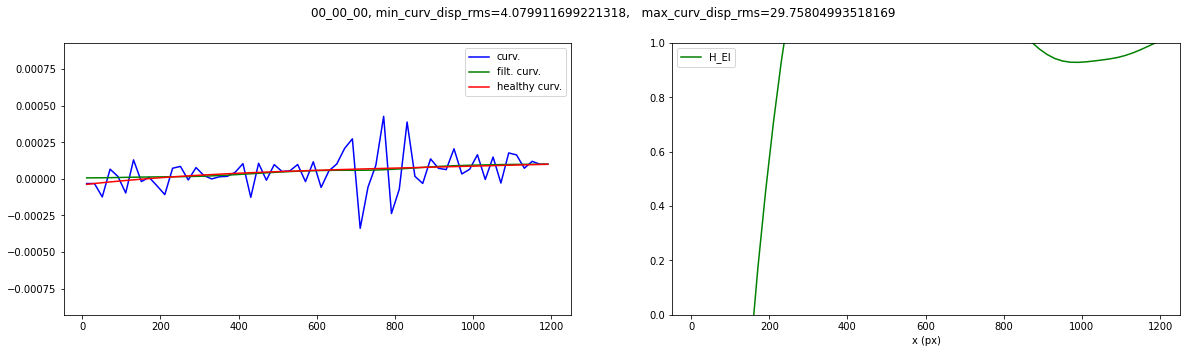

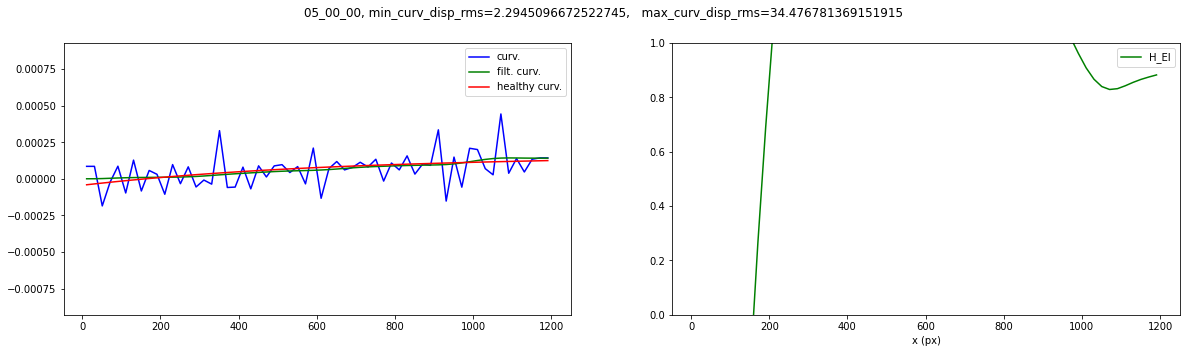

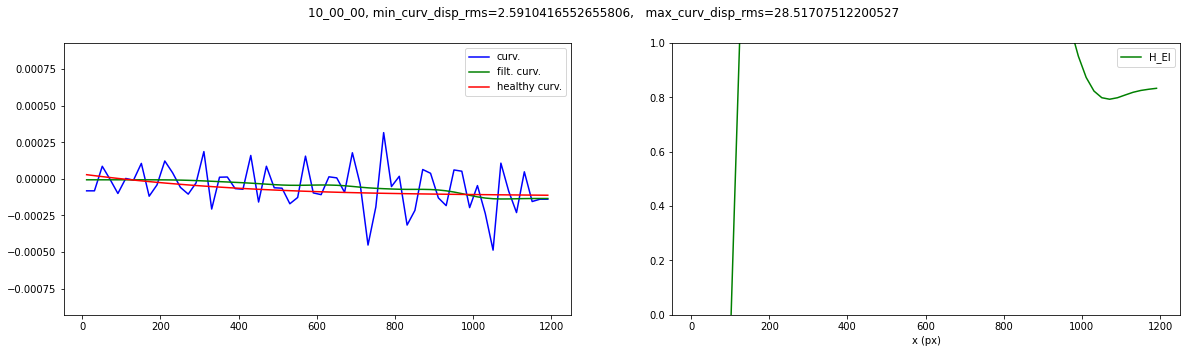

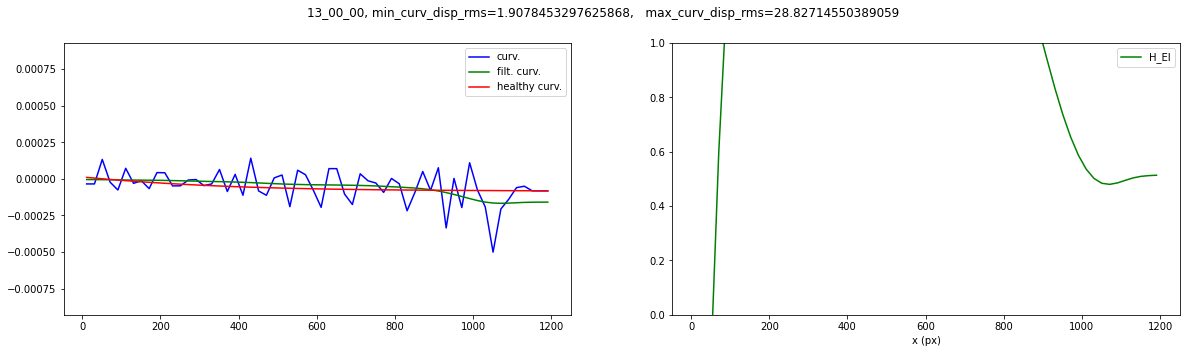

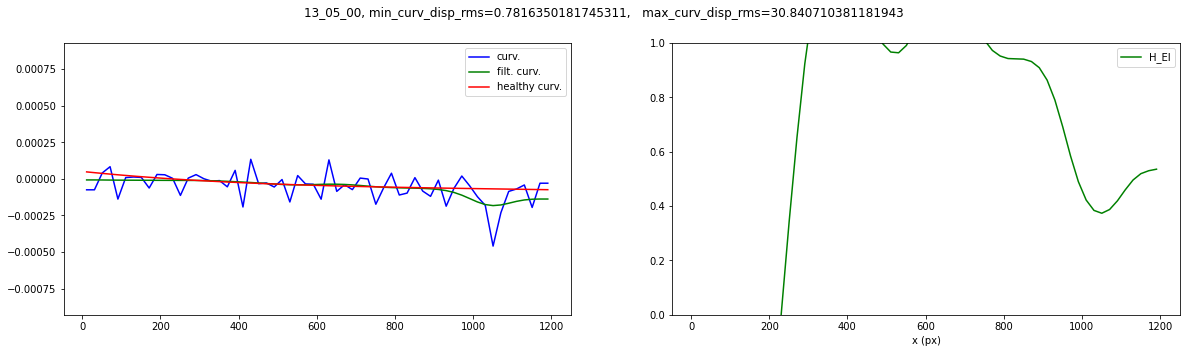

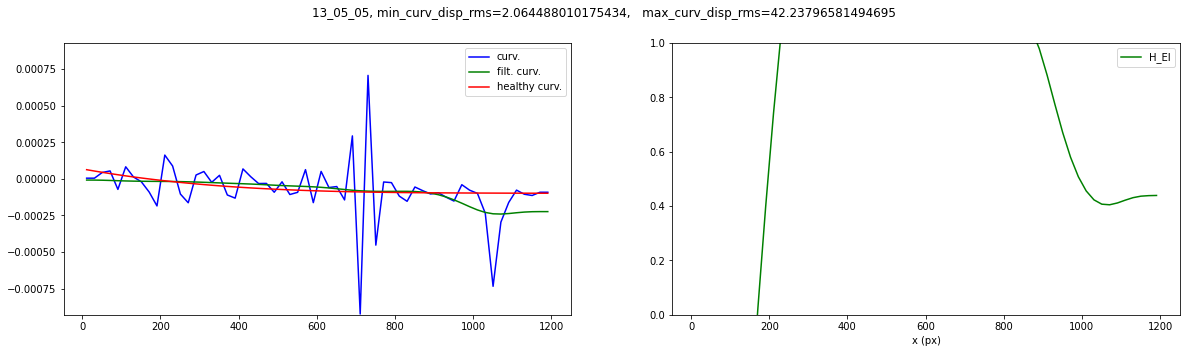

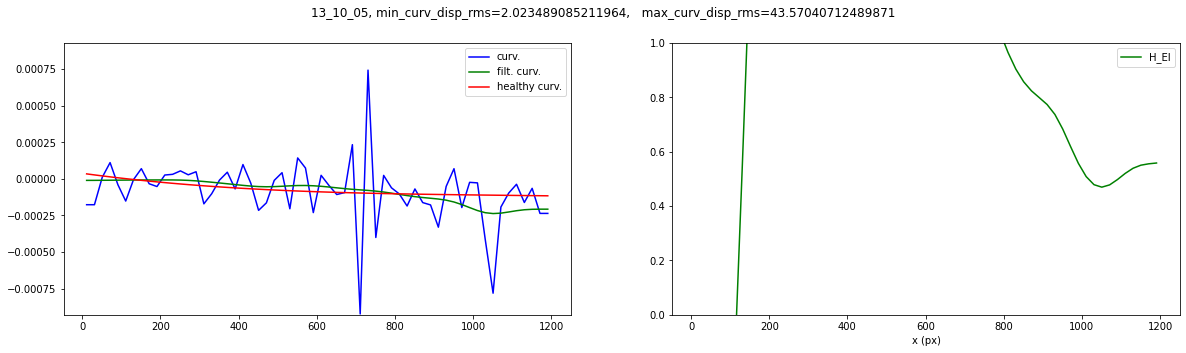

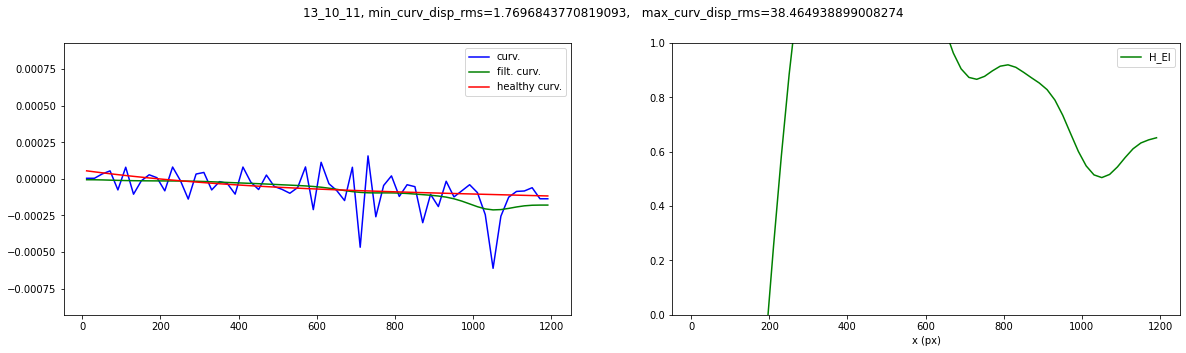

In [ ]:
fig_size = (20, 5)
for key in cases.keys():
  fig2, axs2 = plt.subplots(1, 2, figsize=fig_size, sharex=True)
  # axs2 = [axs2]
  fig2.suptitle(f"{key[0:-5]}, min_curv_disp_rms={cases[key]['min_curv_disp_rms']}, \
  max_curv_disp_rms={cases[key]['max_curv_disp_rms']}")
  axs2[0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
              color='blue', label='curv.')
  axs2[0].plot(cases[key]['max_curv_filt_rts_adapt']['x'], cases[key]['max_curv_filt_rts_adapt']['C'],
              color='green', label='filt. curv.')
  axs2[0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C_h'],
              color='red', linestyle='-', label='healthy curv.')
  axs2[0].legend()
  axs2[0].set_ylim((-max_curv_lim, max_curv_lim))
  axs2[1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI'],
              color='green', linestyle='-', label='H_EI')
  axs2[1].legend()
  axs2[1].set_xlabel('x (px)')  
  axs2[1].set_ylim((0, 1))
